## The code fwd_selection_daily.py repeats the logistic regression fit to SCW events, from our 2021 JSHESS paper, but separately for each type of SCW environment that we found in our case study paper

### Here, test if discriminatory skill is signiicantly better or not

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from event_analysis import optimise_pss, pss
from merge_data import get_env_clusters
from sklearn.metrics import roc_auc_score

In [4]:
def load_data(model,event):
    
    #Load diagnostics/events
    if model == "era5":
            pss_df, df_aws, df_sta = optimise_pss("/g/data/eg3/ab4502/ExtremeWind/points/"+\
                    "era5_allvars_v3_2005_2018.pkl", T=1000, compute=False, l_thresh=2,\
                    is_pss="hss", model_name="era5_v5")
    elif model == "barra":
            pss_df, df_aws, df_sta = optimise_pss("/g/data/eg3/ab4502/ExtremeWind/points/"+\
                    "barra_allvars_v3_2005_2018.pkl", T=1000, compute=False, l_thresh=2,\
                    is_pss="hss", model_name="barra_fc_v5")
    else:
            raise ValueError("Invalid model name")

    #Set the correct dataframe based on event type 
    if event=="is_sta":
            df = df_sta.reset_index().drop(columns="index")
    elif event=="is_conv_aws":
            df = df_aws.reset_index().drop(columns="index")

    #Load clustering classification model saved by ~/working/observations/tint_processing/auto_case_driver/kmeans_and_cluster_eval.ipynb
    cluster_mod, cluster_input = get_env_clusters()
    input_df = (df[["s06","qmean01","lr13","Umean06"]]\
               - cluster_input.min(axis=0))\
        / (cluster_input.max(axis=0) - \
           cluster_input.min(axis=0))
    df["cluster"] = cluster_mod.predict(input_df)
    
    return df

def mod_proba(df, model):
    terms = []
    for name, row in model.iterrows():
        if name=="const":
            terms.append(row["coef"] * np.ones(df.shape[0]))
        else:
            terms.append((df[name]*row["coef"]).values)
    
    return 1 / ( 1 + np.exp(- np.sum(np.stack(terms),axis=0) ) )



/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### First just test for ERA5 fit to measured events (where measured is 25 m/s AWS gust + lightning from 6-hourly data)

In [48]:
model="era5"
event="is_conv_aws"
df = load_data(model,event)

In [45]:
model_0 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/logit_fwd_sel_cluster_1_is_conv_aws_era5.csv",index_col=0)    #Strong BG wind
model_1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/logit_fwd_sel_cluster_2_is_conv_aws_era5.csv",index_col=0)    #Steep LR
model_2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/logit_fwd_sel_cluster_0_is_conv_aws_era5.csv",index_col=0)    #High moisture
model_all = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/logit_fwd_sel_cluster_all_is_conv_aws_era5.csv",index_col=0)    #All

BDSD for all events AUC:  0.954040239710278
BDSD for strong background wind events AUC:  0.9681476058034914
Updated model for strong background wind events AUC:  0.9797193953842079
BDSD for steep lapse rate events AUC:  0.930790842445837
Updated model for steep lapse rate events AUC:  0.9192718188147602
BDSD for high moisture events AUC:  0.9459716614692012
Updated model for high moisture events AUC:  0.9267972899023091


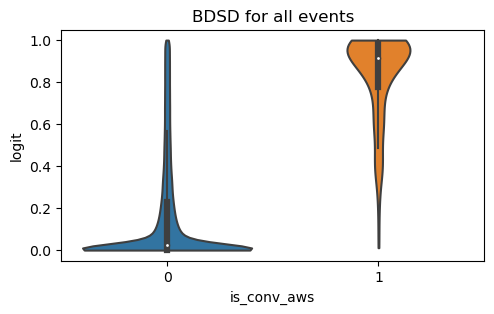

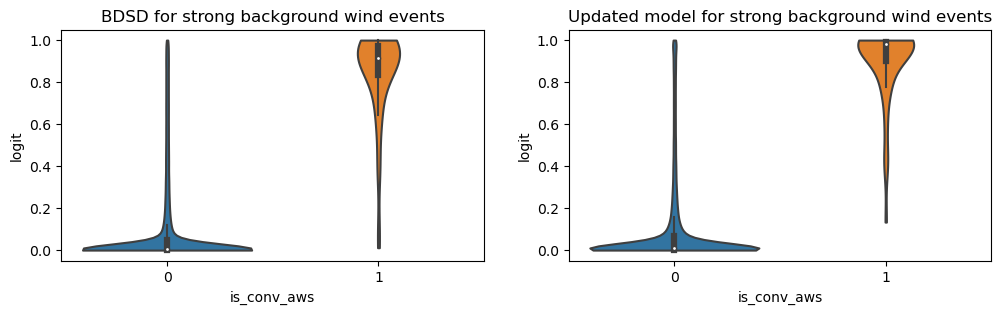

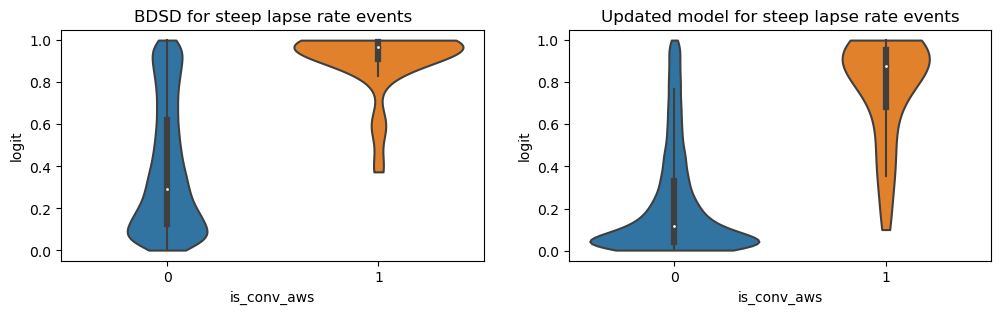

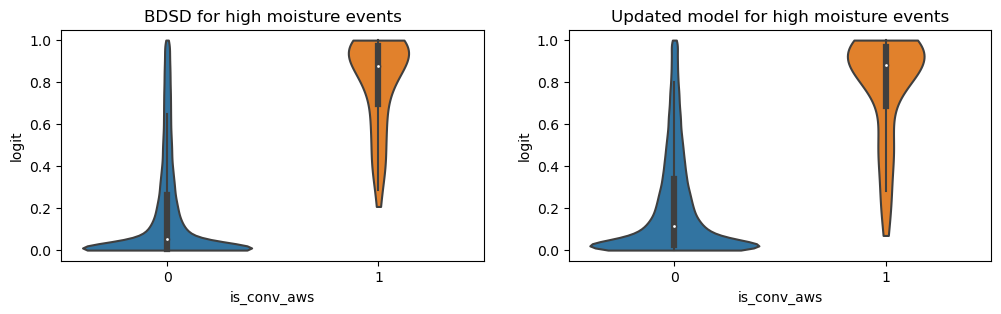

In [73]:
def plot_box(ax,df,event,model,title):
    proba = mod_proba(df,model)
    df["logit"] = proba
    sns.violinplot(data=df,x=event,y="logit",ax=ax,cut=0)
    ax.set_title(title)
    print(title,"AUC: ",roc_auc_score(df[event],df["logit"]))

plt.figure(figsize=[12,3])
plot_box(plt.subplot(1,2,1), df, event, model_all, "BDSD for all events")

plt.figure(figsize=[12,3])
plot_box(plt.subplot(1,2,1), df[df["cluster"]==1].copy(), event, model_all, "BDSD for strong background wind events")
plot_box(plt.subplot(1,2,2), df[df["cluster"]==1].copy(), event, model_0, "Updated model for strong background wind events")

plt.figure(figsize=[12,3])
plot_box(plt.subplot(1,2,1), df[df["cluster"]==2].copy(), event, model_all, "BDSD for steep lapse rate events")
plot_box(plt.subplot(1,2,2), df[df["cluster"]==2].copy(), event, model_1, "Updated model for steep lapse rate events")

plt.figure(figsize=[12,3])
plot_box(plt.subplot(1,2,1), df[df["cluster"]==0].copy(), event, model_all, "BDSD for high moisture events")
plot_box(plt.subplot(1,2,2), df[df["cluster"]==0].copy(), event, model_2, "Updated model for high moisture events")